In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load and clean data
df = pd.read_csv("C:/Users/Subashree/Downloads/f2.csv")  # Replace with your actual file
df['Fertilizer'] = df['Fertilizer'].str.strip().replace({'Ureas': 'Urea'})

# Encode categorical features
le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_fert = LabelEncoder()

df['Soil_Type_Encoded'] = le_soil.fit_transform(df['Soil_Type'].astype(str))
df['Crop_Type_Encoded'] = le_crop.fit_transform(df['Crop_Type'].astype(str))
df['Fertilizer_Label'] = le_fert.fit_transform(df['Fertilizer'].astype(str))

# Save encoders
joblib.dump(le_soil, "soil_encoder.pkl")
joblib.dump(le_crop, "crop_encoder.pkl")
joblib.dump(le_fert, "fertilizer_encoder.pkl")

# Features and target
X = df[['Temparature', 'Humidity', 'Moisture', 'Soil_Type_Encoded', 'Crop_Type_Encoded',
        'Nitrogen', 'Potassium', 'Phosphorous']]
y = df['Fertilizer_Label']
y_cat = to_categorical(y)

# Scale and reshape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")
X_reshaped = X_scaled.reshape(-1, X_scaled.shape[1], 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_cat, test_size=0.2, random_state=42)

# CNN model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Save model
model.save("fertilizer_model.keras")


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3402 - loss: 2.0573 - val_accuracy: 0.3000 - val_loss: 2.3441
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5890 - loss: 1.2711 - val_accuracy: 0.5636 - val_loss: 2.1899
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7443 - loss: 0.8264 - val_accuracy: 0.7364 - val_loss: 2.0173
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8196 - loss: 0.6179 - val_accuracy: 0.7455 - val_loss: 1.8681
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8767 - loss: 0.4402 - val_accuracy: 0.8545 - val_loss: 1.6966
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9224 - loss: 0.3112 - val_accuracy: 0.8545 - val_loss: 1.5651
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9521 - loss: 0.2268 - val_accuracy: 0.9182 - val_loss: 1.4043
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9452 - loss: 0.2023 - val_accuracy: 0.9364 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 


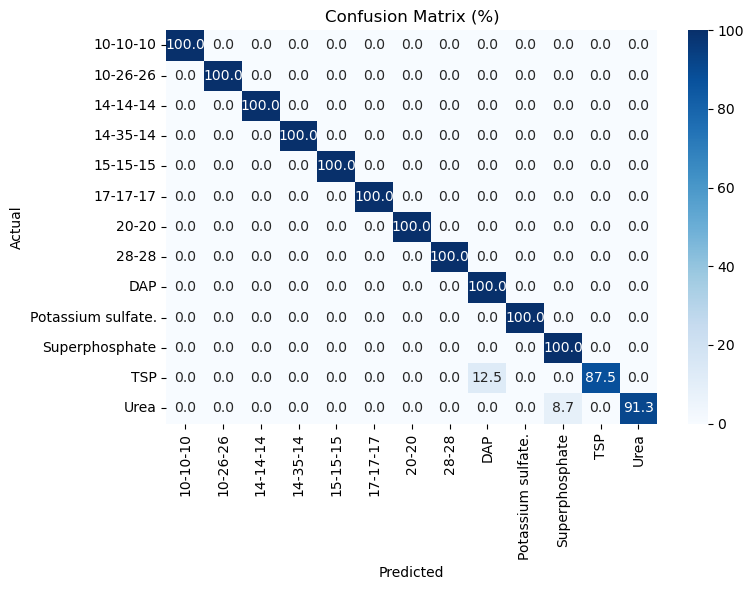

📊 Classification Report:
                    precision    recall  f1-score   support

          10-10-10       1.00      1.00      1.00         4
          10-26-26       1.00      1.00      1.00         8
          14-14-14       1.00      1.00      1.00         3
          14-35-14       1.00      1.00      1.00        10
          15-15-15       1.00      1.00      1.00         1
          17-17-17       1.00      1.00      1.00         4
             20-20       1.00      1.00      1.00        10
             28-28       1.00      1.00      1.00        20
               DAP       0.93      1.00      0.97        14
Potassium sulfate.       1.00      1.00      1.00         2
    Superphosphate       0.60      1.00      0.75         3
               TSP       1.00      0.88      0.93         8
              Urea       1.00      0.91      0.95        23

          accuracy                           0.97       110
         macro avg       0.96      0.98      0.97       110
      weighte

In [11]:
# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

# Confusion matrix (percent)
cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=le_fert.classes_,
            yticklabels=le_fert.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Classification report
report = classification_report(y_val_true_labels, y_val_pred_labels, target_names=le_fert.classes_, digits=2)
print("📊 Classification Report:")
print(report)

# Optional: Save report
with open("classification_report.txt", "w") as f:
    f.write(report)
